**Basic Time Series Analysis on Cryptocurrency Historical Prices**

In [1]:
import numpy as np 
import pandas as pd 
import os
#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))



In [2]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [5]:
df = pd.read_csv('bitcoin_cash_price.csv')
df.head(3)

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Feb 20, 2018",1543.27,1569.03,1414.35,1418.73,"820,947,000","26,199,800,000"
1,"Feb 19, 2018",1483.34,1553.81,1483.34,1534.77,"578,906,000","25,179,700,000"
2,"Feb 18, 2018",1552.10,1641.40,1428.49,1487.46,"907,873,000","26,344,200,000"


In [6]:
print (df.describe())


              Open         High          Low        Close
count   213.000000   213.000000   213.000000   213.000000
mean   1103.532911  1199.696995  1014.952723  1106.705258
std     820.862352   892.000513   743.532709   819.384547
min     212.180000   223.700000   200.980000   213.150000
25%     420.470000   450.980000   395.740000   421.030000
50%     670.030000   756.930000   624.300000   690.240000
75%    1580.160000  1673.230000  1498.000000  1576.920000
max    3909.000000  4355.620000  3038.010000  3923.070000


In [7]:
print (df.dtypes)

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume         object
Market Cap     object
dtype: object


In [8]:
df1 = df[['Date','Close']]
df1.head(3)

,Date,Close
0,"Feb 20, 2018",1418.73
1,"Feb 19, 2018",1534.77
2,"Feb 18, 2018",1487.46


In [9]:
# Setting the Date as Index
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
print (type(df_ts))
print (df_ts.head(3))
print (df_ts.tail(3))

<class 'pandas.core.frame.DataFrame'>
               Close
Date                
Aug 01, 2017  380.01
Aug 02, 2017  452.66
Aug 03, 2017  364.05
               Close
Date                
Sep 28, 2017  447.81
Sep 29, 2017  436.77
Sep 30, 2017  432.63


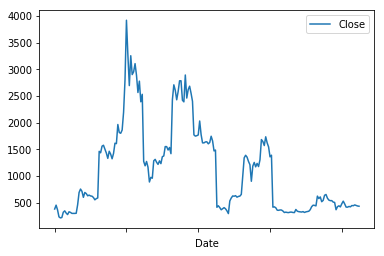

In [10]:
#plot
df_ts.plot()

In [11]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
       
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [12]:
# Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df_ts['Close']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.129441
p-value                          0.232842
#lags Used                       0.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


**Conclusion**

The Test Statistics value is Much higher than critical value. So we can't reject the Null Hypothesis.

Hence from the plot the Time series is Non-Stationary

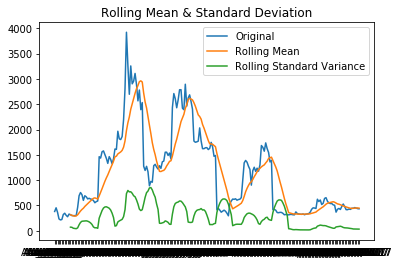

In [13]:
# plot the 12-Month Moving Rolling Mean, Variance 
# Rolling Statistics
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()

plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [14]:
# vanila decomposition to see any trend seasonality in the ts
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

AttributeError: 'Index' object has no attribute 'inferred_freq'

**Conslusion**

Seasonal graph is too stacked . This was obvious by the way as we are analyzing daily data so trying out a Monthly approach

In [15]:
#data by Month and analyze again
df_ts_m = df_ts.resample('M').mean()
print (type(df_ts_m))
print (df_ts_m.head(3))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [16]:
tsm = df_ts_m['Close']
print (type(tsm))

NameError: name 'df_ts_m' is not defined

In [ ]:
# Stationarity Check
test_stationarity(tsm)

In [ ]:
# A quick vanila decomposition 
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

**Conclusion**

Much more clear seasonality graph

In [ ]:
# "tsm" Stationary

tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
# Stationarity Check
test_stationarity(tsmlogdiff)

**Conclusion**

The time series is Stationary now. We can use it now in Forecasting Techniques like ARIMA

In [ ]:
# plot ACF & PACF graphs to visualize AR & MA components
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()